# Metaheuristic course - Session 4

In [36]:
from cars import Car
import matplotlib.pyplot as plt
import numpy as np

## Car racing!

In this session we will be simulating car races. Your goal will be to build the best car! But, depending on the characteristics of your car, it will cost you some money :(

The main characteristics you can modify are:
- `Gas ammount`: This is a value between 0 and 1 and it represents how full is the fuel tank.
- `Aerodynamic`: This value is also between 0 and 1, and it represents how aerodynamic is your car.
- `Cylinder count`: The ammount of cylinders the car engine has (between 1 and 8).
- `Cylinder cc`: The size in cubic centimiters of each cylinder.

Let's build two cars as example:

In [37]:
c1 = Car(gas_ammount=1, aerodynamic=0.8, cylinder_count=4, cylinder_cc=500)
c2 = Car(gas_ammount=1, aerodynamic=0.1, cylinder_count=6, cylinder_cc=600)

Each parameter affects the car when racing:

- Gas ammount affects the weight of the car and the max distance it can run. It also affects the cost (gas is not free).
- Aerodynamic changes how the air resistance affects the car, higher value mean a more aerodynamic car. The higher the speed of the car is, the higher is the air resistance. Aerodynamic also affects the car cost, more aerodynamic means a more expensive bodywork.
- Cylinder count and cylinder cc means a more powerfull engine, but also a more heavier and expensive one.
- The final weight of the car, aerodynamic and engine power determin the car max velocity. Max velocty may change in the middle of a race (as the gas is getting low, the weight reduces, so max velocity increases)

In [38]:
print("C1")
print(f"Weight: {c1.weight}")
print(f"Cost: {c1.cost}")
print(f"Max HP: {c1.max_hp}")

# Velocity is given in m/s so multiply it by 3.6 to get it in km/h
print(f"Max velocity: {c1.max_velocity * 3.6}")

print("\nC2")
print(f"Weight: {c2.weight}")
print(f"Cost: {c2.cost}")
print(f"Max HP: {c2.max_hp}")
print(f"Max velocity: {c2.max_velocity * 3.6}")

C1
Weight: 893.1360403634043
Cost: 7447.835
Max HP: 200.0
Max velocity: 170.3564931100798

C2
Weight: 908.5197321350671
Cost: 8327.835
Max HP: 360.0
Max velocity: 226.61391254496067


Let's race this two cars for 500m:

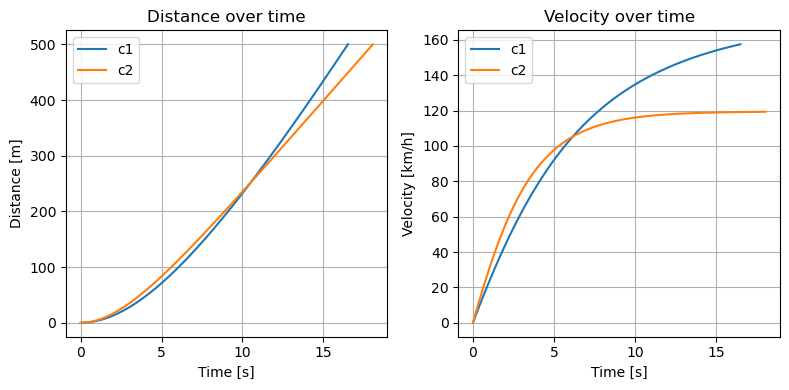

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
for i, c in enumerate([c1, c2]):
    data = []
    for state in c.simulate_race(max_distance=500):
        data.append(
            [
                state.time,
                state.distance,
                state.velocity,
            ]
        )

    arr = np.array(data)
    time = arr[:, 0]
    distance = arr[:, 1]
    velocity = arr[:, 2]

    ax[0].grid(True)
    ax[0].plot(time, distance, label=f"c{i+1}")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Distance [m]")
    ax[0].set_title("Distance over time")
    ax[0].legend()

    ax[1].grid(True)
    ax[1].plot(time, velocity * 3.6, label=f"c{i+1}")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Velocity [km/h]")
    ax[1].set_title("Velocity over time")
    ax[1].legend()

plt.tight_layout()
plt.show()

As you can see, `c1` may seems less powerfull, but it has better aerodynamic bodywork than `c2`, so, it has better performance than `c2` in higher velocities. Also, `c2` max velocity was higher than `c1`, but this doesn't take into account the air resistance, so you must simulate the race to really know the car performance.

You can also run the simulation in a single call using the `race` method:

In [40]:
print(c1.race(max_distance=500))
print(c2.race(max_distance=500))

CarState(distance=500.2422242189768, velocity=43.74538342502209, time=16.519999999999783, gas=104.71523311475107)
CarState(distance=500.204858236162, velocity=33.137102257836034, time=18.060000000000024, gas=104.4396366885135)


## Time to code!

In [41]:
import math
import random
from typing import Callable
from metaheuristics import MetaHeuristic

class ParticleSwarmMetaheuristic(MetaHeuristic):
    def __init__(self, init_population_length, cost_limit, distance) -> None:
        super().__init__()
        self.init_population_length = init_population_length
        self.cost_limit = cost_limit
        self.distance = distance

    def _time_to_run_distance_given_cost_limit(self, solution_vector):
        car = Car(gas_ammount=solution_vector[0], aerodynamic=solution_vector[1], cylinder_count=solution_vector[2], cylinder_cc=solution_vector[3])
        if car.cost > self.cost_limit:
            return math.inf
        final_sate = car.race(self.distance)
        return final_sate.time

    def solve(self, obj_func: Callable):
        particles = self._generate_population(population_length=self.init_population_length, cost_limit=self.cost_limit)
        velocity_dimension_i = [0.01, 0.01, 1, 100] # init velocity values
        range_dimension_i = [(0, 1), (0, 1), (1, 8), (100, 10000)]
        best_sol = None
        val = math.inf
        found_best = True
        while found_best:
            found_best = False

            # Update best solution
            for i in range(len(particles)):
                sol = particles[i]
                new_val = obj_func(sol)
                if new_val < val:
                    found_best = True
                    best_sol = sol
                    val = new_val
            
            # Move particles
            for i in range(len(particles)):
                particle = particles[i]
                for j in range(len(particle)):
                    w = 0.9 - (0.9 - 0.4)*random.random()
                    c1 = random.random()
                    upper_bound_dim = range_dimension_i[j][1]
                    lower_bound_dim = range_dimension_i[j][0]
                    new_velocity_dim_i = w*velocity_dimension_i[j] + c1*(best_sol[j]-particle[j])
                    if lower_bound_dim <= particle[j] + new_velocity_dim_i <= upper_bound_dim:
                        velocity_dimension_i[j] =   new_velocity_dim_i
                        particle[j] = particle[j] + velocity_dimension_i[j] 

            yield best_sol, val

    def _generate_population(self, population_length, cost_limit):
        population = []
        while len(population) < population_length:
            gas_amount = random.random()
            aerodynamic = random.random()
            cylinder_count = random.randint(1, 8)
            cylinder_cc = random.randint(100, 10000)
            car = Car(gas_ammount=gas_amount, aerodynamic=aerodynamic, cylinder_count=cylinder_count, cylinder_cc=cylinder_cc)
            if car.cost > cost_limit:
                continue
            member = [gas_amount, aerodynamic, cylinder_count, cylinder_cc]
            population.append(member)
        return population
    
# Eval metaheuristic
mh = ParticleSwarmMetaheuristic(init_population_length=100, cost_limit=10000, distance=500)
ev = mh.evaluate(
    mh._time_to_run_distance_given_cost_limit,
    max_evals=400,
    max_iters=100,
    max_time=11,
)
print(ev)

Evaluating ParticleSwarmMetaheuristic
10.892s - Last value: 3.799999999999963 - Last solution: [0.008023007706416063, 0.932549623435161, 3, 9776.114914194859]508.234430223414]
Evaluation of ParticleSwarmMetaheuristic:
  best result --------------- [0.008023007706416063, 0.932549623435161, 3, 9776.114914194859]
  success ------------------- True
  iters --------------------- 3
  evals --------------------- 300
  time ---------------------- 10.894438743591309
  approx. evals per iter ---- 100.0
  approx. iter time --------- 3.631479581197103

